Extraction directory already exists: C:\Users\acer\Downloads\Vehicles_Extracted
Zip file extracted successfully.
Loaded all_alpha_08(all_alpha_08).csv successfully.
Loaded all_alpha_09(all_alpha_09).csv successfully.
Loaded all_alpha_10(all_alpha_10).csv successfully.
Loaded all_alpha_12(all_alpha_12).csv successfully.
Loaded all_alpha_13(all_alpha_13).csv successfully.
Loaded all_alpha_14(all_alpha_14).csv successfully.
Loaded all_alpha_15(all_alpha_15).csv successfully.
Loaded all_alpha_16(all_alpha_16).csv successfully.
Loaded all_alpha_17(all_alpha_17).csv successfully.
Loaded all_alpha_18(all_alpha_18).csv successfully.
✅ All required columns are available.

Year: 2008
Samples: 2404, Columns: 19
Duplicate Rows: 25
Data Types:
Model                    object
Displ                   float64
Cyl                      object
Trans                    object
Drive                    object
Fuel                     object
Sales Area               object
Stnd                     object
Und

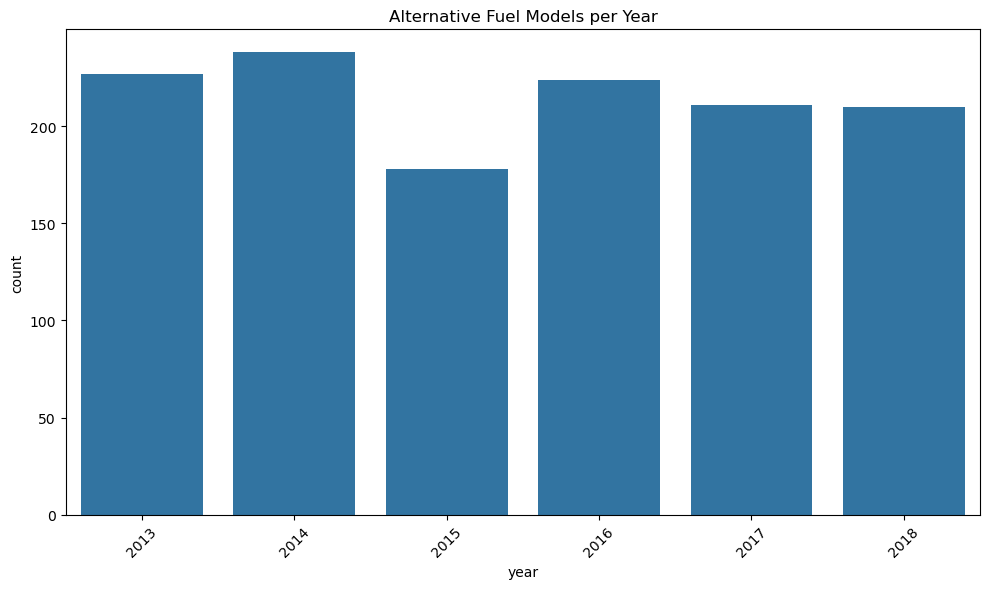

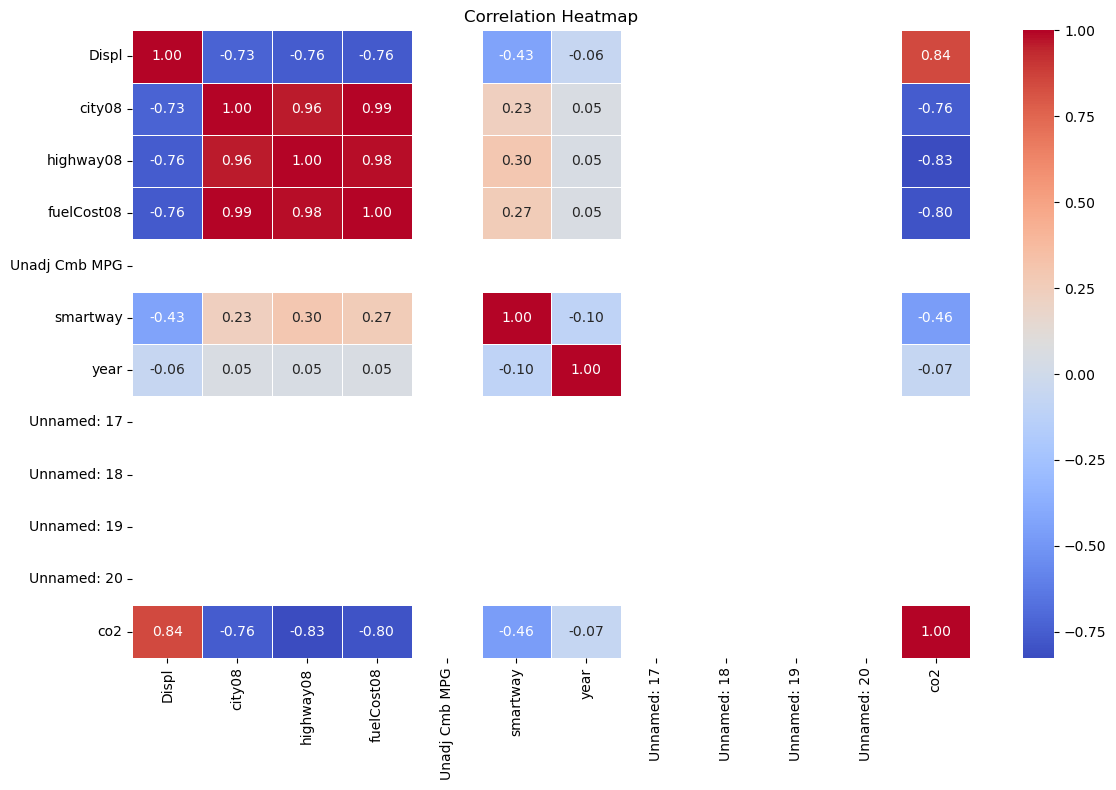

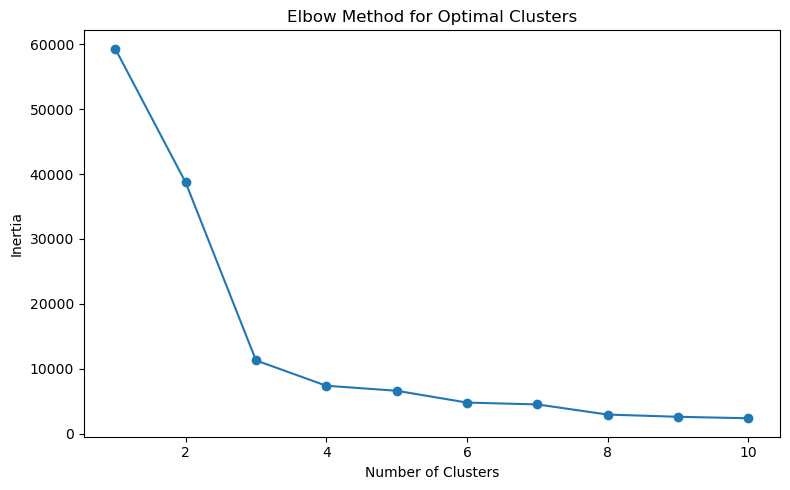

✅ Clustering complete. Cluster labels added to 'merged_data'.
Logistic Regression Accuracy: 0.9123398516520567
Decision Tree Accuracy: 0.9248145650708024


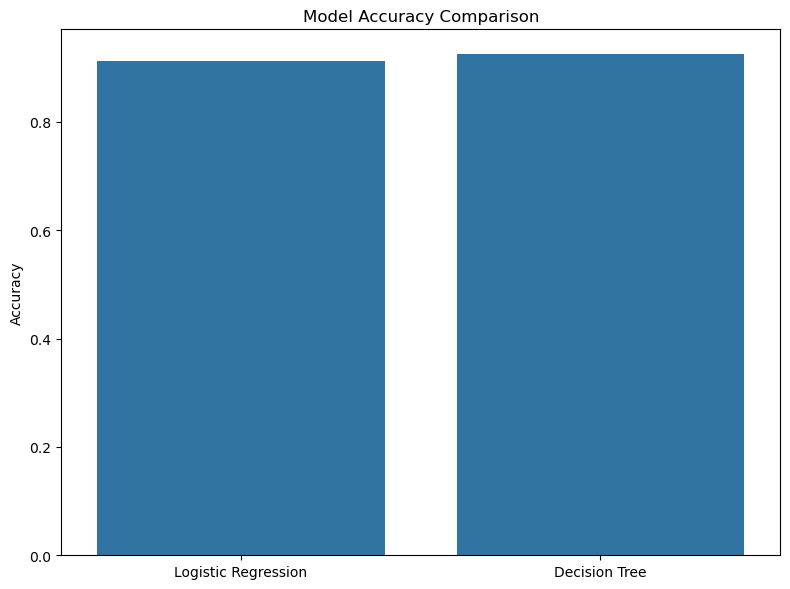

Linear Regression MSE: 0.45324976587067123

📌 Conclusion:
- ✅ Successfully loaded and analyzed vehicle data from 2008–2018.
- ✅ Clustered vehicle data into 3 groups based on fuel metrics.
- ✅ Built classification models to predict SmartWay status.
- ✅ Built regression model to predict city MPG.


In [9]:
#🚗 Capstone Project: Fuel Economy Analysis and Predictive Modelling (2008–2018)

import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# Paths
zip_path = r'C:\Users\acer\Downloads\Vehicles Zip (2008-2018).zip'
extract_dir = r'C:\Users\acer\Downloads\Vehicles_Extracted'

# Extract ZIP
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
    print(f"Created extraction directory at: {extract_dir}")
else:
    print(f"Extraction directory already exists: {extract_dir}")

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        print("Zip file extracted successfully.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_path}")
    exit()
except zipfile.BadZipFile:
    print("Error: Bad zip file. Please check if the file is corrupted.")
    exit()
except Exception as e:
    print(f"Unexpected error during extraction: {e}")
    exit()

# Load CSV files
dataframes = {}
for year in range(2008, 2019):
    filename = f"all_alpha_{str(year)[-2:]}(all_alpha_{str(year)[-2:]})"
    filepath = os.path.join(extract_dir, filename + '.csv')
    try:
        df = pd.read_csv(filepath)
        df['year'] = year
        dataframes[year] = df
        print(f"Loaded {filename}.csv successfully.")
    except FileNotFoundError:
        print(f"Warning: File for year {year} not found: {filepath}")
    except Exception as e:
        print(f"Error loading file for year {year}: {e}")

# Combine data
merged_data = pd.concat(dataframes.values(), ignore_index=True)
merged_data.reset_index(drop=True, inplace=True)

# Rename and clean columns
rename_dict = {
    'City MPG': 'city08',
    'Hwy MPG': 'highway08',
    'Cmb MPG': 'fuelCost08',
    'Greenhouse Gas Score': 'greenhouse_gas_score',
    'SmartWay': 'smartway',
    'Comb CO2': 'co2'
}
merged_data.rename(columns=rename_dict, inplace=True)
merged_data.columns = merged_data.columns.str.strip()

# Required columns check
required_cols = ['city08', 'highway08', 'co2', 'fuelCost08', 'smartway']
missing_cols = [col for col in required_cols if col not in merged_data.columns]
if missing_cols:
    print("❌ Missing required columns even after renaming:", missing_cols)
else:
    print("✅ All required columns are available.")

# Convert to numeric
for col in ['city08', 'highway08', 'co2', 'fuelCost08']:
    merged_data[col] = merged_data[col].astype(str).str.replace(',', '').str.extract(r'(\d+\.?\d*)')[0]
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Binary mapping
merged_data['smartway'] = merged_data['smartway'].map({'Yes': 1, 'No': 0})
merged_data['smartway'] = merged_data['smartway'].fillna(0)

# Drop missing values
merged_data.dropna(subset=required_cols, inplace=True)

# Dataset analysis per year
def analyze_dataset(data, year):
    print(f"\nYear: {year}")
    print(f"Samples: {data.shape[0]}, Columns: {data.shape[1]}")
    print(f"Duplicate Rows: {data.duplicated().sum()}")
    print(f"Data Types:\n{data.dtypes}")
    print(f"Missing Values:\n{data.isnull().sum()}")

for year, data in dataframes.items():
    analyze_dataset(data, year)

# Alternative fuel plot
plt.figure(figsize=(10, 6))
alt_fuel_models = merged_data[merged_data['Fuel'].str.contains('Electricity|Ethanol|Natural Gas', na=False)]
sns.countplot(data=alt_fuel_models, x='year')
plt.title('Alternative Fuel Models per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap
numeric_data = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Clustering (K-Means)
cluster_cols = ['city08', 'highway08', 'co2', 'fuelCost08']
features = merged_data[cluster_cols].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# Final clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(scaled_features)
print("✅ Clustering complete. Cluster labels added to 'merged_data'.")

# Predictive Modeling
X = merged_data[cluster_cols]
y = merged_data['smartway']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Accuracy:", log_accuracy)

# Decision Tree
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Accuracy:", tree_accuracy)

# Accuracy comparison
models = ['Logistic Regression', 'Decision Tree']
accuracies = [log_accuracy, tree_accuracy]
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Linear Regression
reg_cols = ['highway08', 'co2', 'fuelCost08', 'city08']
if all(col in merged_data.columns for col in reg_cols):
    reg_features = merged_data[['highway08', 'co2', 'fuelCost08']]
    reg_target = merged_data['city08']
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(reg_features, reg_target, test_size=0.2, random_state=42)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_reg, y_train_reg)
    y_pred_reg = lin_reg.predict(X_test_reg)
    print("Linear Regression MSE:", mean_squared_error(y_test_reg, y_pred_reg))
else:
    print("❌ Required columns for regression are missing.")

# Conclusion
print("\n📌 Conclusion:")
print("- ✅ Successfully loaded and analyzed vehicle data from 2008–2018.")
print("- ✅ Clustered vehicle data into 3 groups based on fuel metrics.")
print("- ✅ Built classification models to predict SmartWay status.")
print("- ✅ Built regression model to predict city MPG.")
